StyleAligned Project

Link to original paper: https://arxiv.org/abs/2312.02133

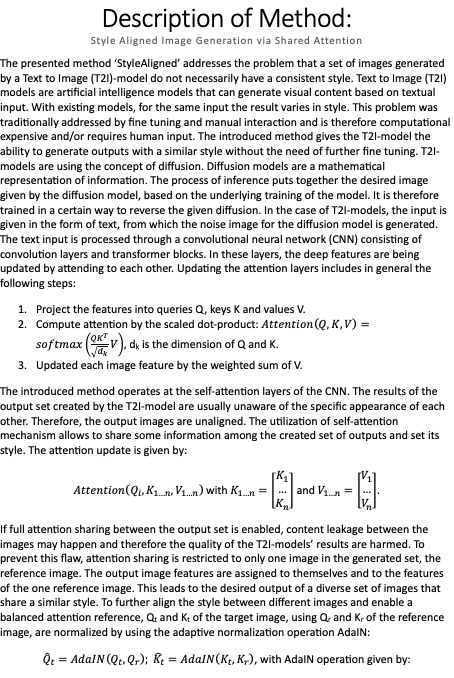

In [ ]:
# Diffuser model from: huggingface.co
!pip install diffusers==0.20.2
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342632 sha256=1dbec15f165e1213b843a83a39a7aef2c63c7464daf7fcb59d8f898cd9d121dc
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as nnf # for AdaIN
import torch.nn as nn
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

from diffusers.models import attention_processor # necessary for attention processing

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from PIL import Image

#load autoencoder model, used to decode the latents into image space --> from CompVis
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-3", subfolder="vae")

#load tokenizer and text encoder to tokenize and encode the text --> from CompVis
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

vae/config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
#load UNet model for generating the latents --> from CompVis
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-3", subfolder="unet")

unet/config.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
#load new scheduler --> from CompVis
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-3", subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

In [ ]:
#move everything to gpu
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Preparing StlyeAligned

In [ ]:
# adds style dimension
def expand_with_reference(feat): #
    style = feat
    b = feat.shape[0]
    if is_reference:
      style = torch.stack((feat[0], feat[b // 2])).unsqueeze(1)
      save_feat(style)

    else:
      style = load_feat()

    style = style.expand(2, b // 2, *feat.shape[1:])

    return style.reshape(*feat.shape)

# concatenates original and style tensor along specified dimension
def concat_with_reference(feat, dim=2):
    style = expand_with_reference(feat)
    return torch.cat((feat, style), dim=dim)

# calculate mean and standard deviation, for AdaIN --> from chatgpt
def calc_mean_std(feat, eps: float = 1e-5):
    feat_std = (feat.var(dim=-2, keepdims=True) + eps).sqrt()
    feat_mean = feat.mean(dim=-2, keepdims=True)
    return feat_mean, feat_std

# Applies AdaIN to Tensor T. Used for balanced attention --> from chatgpt
def adain(feat):
    feat_mean, feat_std = calc_mean_std(feat)
    style_mean = expand_with_reference(feat_mean)
    style_std = expand_with_reference(feat_std)
    feat = (feat - feat_mean) / feat_std
    feat = feat * style_std + style_mean
    return feat

# nn-module that serves as default attention processor --> modified version of the code from paper
class DefaultAttentionProcessor(nn.Module):

    def __init__(self):
        super().__init__()
        self.processor = attention_processor.AttnProcessor2_0()

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None,
                 attention_mask=None, **kwargs):
        return self.processor(attn, hidden_states, encoder_hidden_states, attention_mask)

# manipulation of v, q and k
# scaled dot-product is applied
# --> modified version of the code from paper
class SharedAttentionProcessor(DefaultAttentionProcessor):
    def __init__(self, share_attn, adain_queries, adain_keys, adain_values):
            super().__init__()
            self.share_attention = share_attn
            self.adain_queries = adain_queries
            self.adain_keys = adain_keys
            self.adain_values = adain_values


    def shared_call(
            self,
            attn: attention_processor.Attention,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            **kwargs
    ):

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        query = attn.to_q(hidden_states)
        key = attn.to_k(hidden_states)
        value = attn.to_v(hidden_states)

        in_dimension = key.shape[-1]
        head_dimension = in_dimension // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dimension).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dimension).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dimension).transpose(1, 2)

        if self.adain_queries:
            query = adain(query)
        if self.adain_keys:
            key = adain(key)
        if self.adain_values:
            value = adain(value)

        if self.share_attention:
            key = concat_with_reference(key, -2)
            value = concat_with_reference(value, -2)
            hidden_states = nnf.scaled_dot_product_attention(
                query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            )

        hidden_states = adain(hidden_states)
        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dimension)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        hidden_states = hidden_states / attn.rescale_output_factor
        return hidden_states

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
      hidden_states = self.shared_call(attn, hidden_states, hidden_states, attention_mask, **kwargs)
      return hidden_states

In [ ]:
# replacing forward function with costum one
def register_shared_norm(share_group_norm = True, share_layer_norm = True):
        def register_norm_forward(norm_layer: nn.GroupNorm | nn.LayerNorm) -> nn.GroupNorm | nn.LayerNorm:
            if not hasattr(norm_layer, 'orig_forward'):
                setattr(norm_layer, 'orig_forward', norm_layer.forward)
            orig_forward = norm_layer.orig_forward

            def forward_(hidden_states: torch.Tensor): #This function will replace the forward function in the unet and will be called during unet forward pass for each norm layer
                n = hidden_states.shape[-2]
                hidden_states = concat_with_reference(hidden_states, dim=-2)
                hidden_states = orig_forward(hidden_states)
                return hidden_states[..., :n, :]

            norm_layer.forward = forward_ #change the standard forward method to our custom one above
            return norm_layer

        def get_norm_layers(pipeline_, norm_layers_: dict[str, list[nn.GroupNorm | nn.LayerNorm]]):
            if isinstance(pipeline_, nn.LayerNorm) and share_layer_norm:
                norm_layers_['layer'].append(pipeline_)
            if isinstance(pipeline_, nn.GroupNorm) and share_group_norm:
                norm_layers_['group'].append(pipeline_)
            else:
                for layer in pipeline_.children():
                    get_norm_layers(layer, norm_layers_)

        norm_layers = {'group': [], 'layer': []}
        get_norm_layers(unet, norm_layers)
        return [register_norm_forward(layer) for layer in norm_layers['group']] + [register_norm_forward(layer) for layer in norm_layers['layer']]


In [ ]:
# create list of shared and default attention processors
def enable_attention_processors():
        attn_procs = {}

        number_of_self, number_of_cross = 0, 0
        self_layer_num = len([name for name in unet.attn_processors.keys() if 'attn1' in name])

        only_self_vec = torch.zeros(self_layer_num, dtype=torch.bool)

        for i, name in enumerate(unet.attn_processors.keys()):
            is_self_attention = 'attn1' in name
            if is_self_attention:
                number_of_self += 1
                if only_self_vec[i // 2]:
                    attn_procs[name] = DefaultAttentionProcessor()
                else:
                    attn_procs[name] = SharedAttentionProcessor(share_attn = True, adain_queries = True,
                                                                adain_keys = True, adain_values = False)

            else:
                number_of_cross += 1
                attn_procs[name] = DefaultAttentionProcessor()

        unet.set_attn_processor(attn_procs)

In [ ]:
def register_stylealigned():
        norm_layers = register_shared_norm()

        enable_attention_processors()

Methods for creating images

In [ ]:
# generating noise
def generate_list_of_latents_with_noise(nr):
  # Indented block starts here
  list_of_latents = []
  for i in range(nr):
    new_latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    new_latents = new_latents.to(torch_device)


    scheduler.set_timesteps(num_inference_steps)

    new_latents = new_latents * scheduler.init_noise_sigma

    list_of_latents.append(new_latents)
  return list_of_latents

# denoising loop
def denoising_loop(lts, text_embeds):
  for t in tqdm(scheduler.timesteps):
    #expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([lts] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    #predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeds).sample

    #perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #compute the previous noisy sample x_t -> x_t-1
    lts = scheduler.step(noise_pred, t, lts).prev_sample
  return lts

# decoding
def decoding(lts):
  # scale
  lts = 1 / 0.18215 * lts

  #decode the image latents with vae
  with torch.no_grad():
    image = vae.decode(lts).sample
  return image

def convert_decoded_to_PIL(image):
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images[0]

# for output set
def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

#Make text embeddings from the prompt
def text_embeddings_from_prompt(text):
  text_input = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  #text embeddings for padding token (empty text)
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

  #put them together so we don't have to do forward pass twice later
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [ ]:
register_stylealigned()

In [ ]:
# free up some ram space, copied from  stackoverflow.com
import gc

def flush_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [ ]:
# handle features of reference image
reference_feat_list = []
def save_feat(feat):
  reference_feat_list.append(feat)
def load_feat():
  return reference_feat_list.pop(0)

Creating a reference image

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

#Create reference image
prompt = ["a giant cat, old cartoon style"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 12            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(69)   # Seed generator to create the inital latent noise

batch_size = 1

is_reference = True

text_embeddings = text_embeddings_from_prompt(prompt)

latents = generate_list_of_latents_with_noise(1)[0]

#DENOISING LOOP
latents = denoising_loop(latents, text_embeddings)

# latents --> image
image = decoding(latents)
dec_im = convert_decoded_to_PIL(image)

<ipython-input-10-69dd68cc024d>:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
pils = []
pils.append(dec_im)

Creating a target image

In [ ]:
#Image to modify, memory limit: only two images can be created
prompt = ["A Lion, old cartoon style"]#, "A picture of a beutiful blond naked bavarian man, style: realistic cartoon"]

is_reference = False

In [ ]:
# create sec image
text_embedding_list = []

for i in range(len(prompt)):
  text_embedding_list.append(text_embeddings_from_prompt(prompt[i]))


number_of_images = len(prompt)
latent_list = generate_list_of_latents_with_noise(number_of_images)


scheduler.set_timesteps(num_inference_steps)
new_latent_list = []
for i in range(len(latent_list)):
  new_latent_list.append(denoising_loop(latent_list[i], text_embedding_list[i]))

<ipython-input-10-69dd68cc024d>:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
images = []

for latent in new_latent_list:
  img = decoding(latent)
  images.append(convert_decoded_to_PIL(img))

In [ ]:
for pil in images:
  pils.append(pil)
grid = image_grid(pils, rows=1, cols=number_of_images+1)

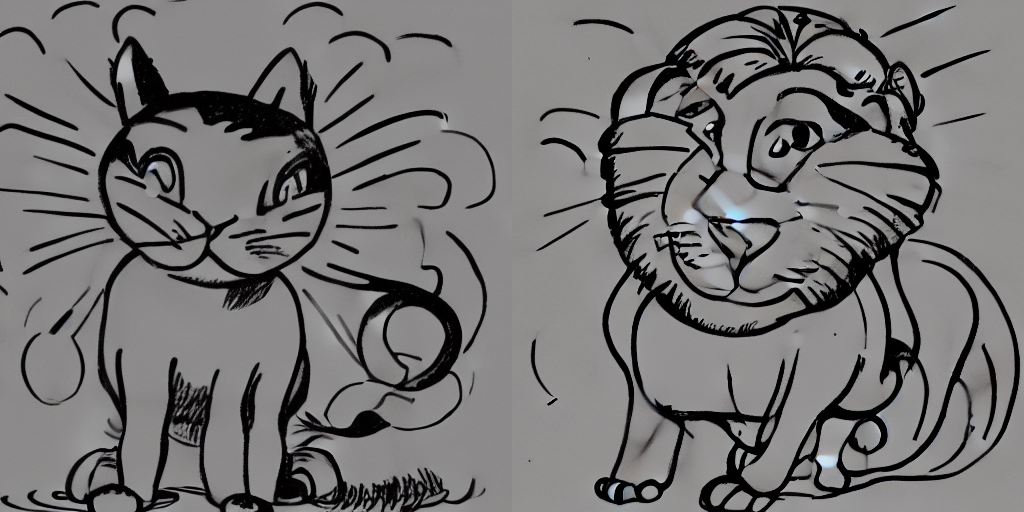

In [ ]:
grid

The left image is the reference and the right one is the target.

It is working. The style is aligned between reference and target. We still observe some artifacts of the reference in the target picture, it is far from perfect.

We scaled the problem down due to hardware limitations. This means a less complex model for the unet, less inference steps in comparison to the original paper. Our implementation is also simplified, and limits us to one reference and one target.